In [2]:
 #Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
bitcoin_df = pd.read_csv('fear_greed_index.csv')
trader_df = pd.read_csv('historical_data.csv')


print("fear_greed_index")
print(bitcoin_df.head())
print("\nhistorical_data")
print(trader_df.head())

fear_greed_index
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

historical_data
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09

In [7]:
trader_df.isna().sum()


Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [10]:
# Convert to datetime
bitcoin_df['date'] = pd.to_datetime(bitcoin_df['date'])
trader_df['Timestamp IST'] = pd.to_datetime(
    trader_df['Timestamp IST'],
    format="%d-%m-%Y %H:%M",
    errors='coerce'
)



In [14]:


#  Extract just the date (without time) to align datasets
trader_df['Date'] = trader_df['Timestamp IST'].dt.date
bitcoin_df['Date'] = bitcoin_df['date'].dt.date

# S Aggregate trader metrics by day
daily_trader = trader_df.groupby('Date').agg({
    'Closed PnL': 'sum',            # total daily profit/loss
    'Size USD': 'sum',              # total daily volume in USD
    'Execution Price': 'mean',      # average execution price
    'Side': lambda x: x.value_counts().idxmax(),  # most common trade side
    'Start Position': 'mean',       # average start position
    'Direction': lambda x: x.value_counts().idxmax(), # dominant direction
    'Fee': 'sum',                   # total fee per day
    'Size Tokens': 'sum'            # total tokens traded
}).reset_index()



In [15]:
# Merge aggregated trader metrics with market sentiment
merged_df = pd.merge(
    bitcoin_df[['Date', 'classification']],  # only Date and sentiment
    daily_trader,
    on='Date',
    how='inner'
)


In [17]:

print(merged_df.head())

# Step 6: Save processed CSV for submission
merged_df.to_csv('merged_trader_sentiment.csv', index=False)


         Date classification  Closed PnL   Size USD  Execution Price  Side  \
0  2023-05-01          Greed    0.000000     477.00      1898.133333   BUY   
1  2023-12-05  Extreme Greed    0.000000   50005.83     11038.300000   BUY   
2  2023-12-14          Greed -205.434737  113203.35      8031.868818  SELL   
3  2023-12-15          Greed  -24.632034   10609.95         2.982000   BUY   
4  2023-12-16          Greed    0.000000   15348.77         0.384707   BUY   

   Start Position    Direction        Fee  Size Tokens  
0        0.091933    Open Long   0.000000      0.25130  
1        2.513867    Open Long  12.501455     11.80901  
2     -132.574302   Close Long  28.300831   4092.28901  
3    -2440.000000  Close Short   2.652489   3558.00000  
4    12124.666667    Open Long   3.837189  39897.00000  


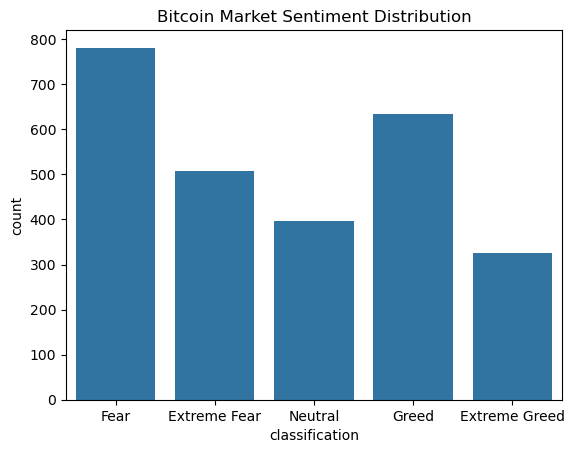

In [19]:

# Basic Visualizations

# 1. Sentiment distribution
sns.countplot(x='classification', data=bitcoin_df)
plt.title("Bitcoin Market Sentiment Distribution")
plt.savefig('outputs/market_sentiment.png')
plt.show()



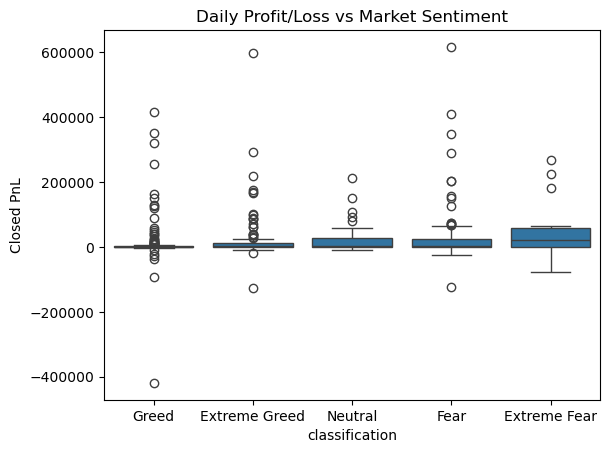

In [20]:
# 2. Profit/Loss vs Sentiment
sns.boxplot(x='classification', y='Closed PnL', data=merged_df)
plt.title("Daily Profit/Loss vs Market Sentiment")
plt.savefig('outputs/pnl_vs_sentiment.png')
plt.show()



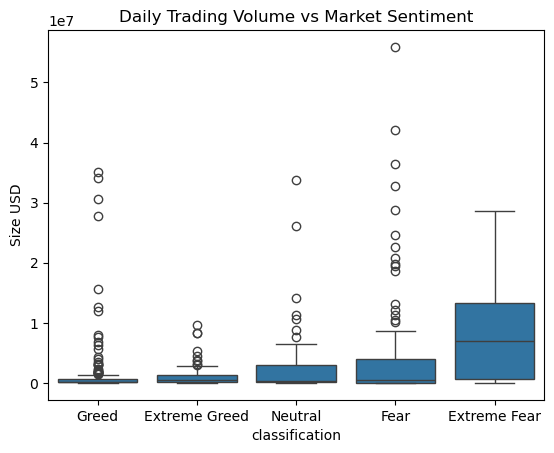

In [21]:
# 3. Trading Volume vs Sentiment
sns.boxplot(x='classification', y='Size USD', data=merged_df)
plt.title("Daily Trading Volume vs Market Sentiment")
plt.savefig('outputs/volume_vs_sentiment.png')
plt.show()

  classification    Closed PnL
0   Extreme Fear  52793.589178
1  Extreme Greed  23817.292199
2           Fear  36891.818040
3          Greed  11140.566181
4        Neutral  19297.323516


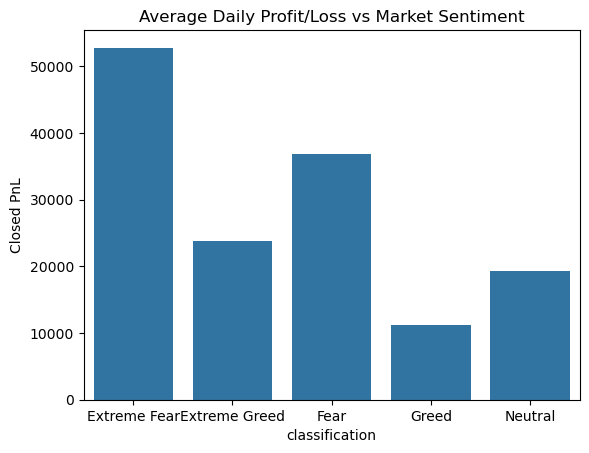

In [22]:
# Average daily PnL by sentiment
pnl_trend = merged_df.groupby('classification')['Closed PnL'].mean().reset_index()
print(pnl_trend)

# Plot
sns.barplot(x='classification', y='Closed PnL', data=pnl_trend)
plt.title("Average Daily Profit/Loss vs Market Sentiment")
plt.savefig('outputs/avg_pnl_vs_sentiment.png')
plt.show()

  classification      Size USD
0   Extreme Fear  8.177447e+06
1  Extreme Greed  1.091800e+06
2           Fear  5.311261e+06
3          Greed  1.495246e+06
4        Neutral  2.690180e+06


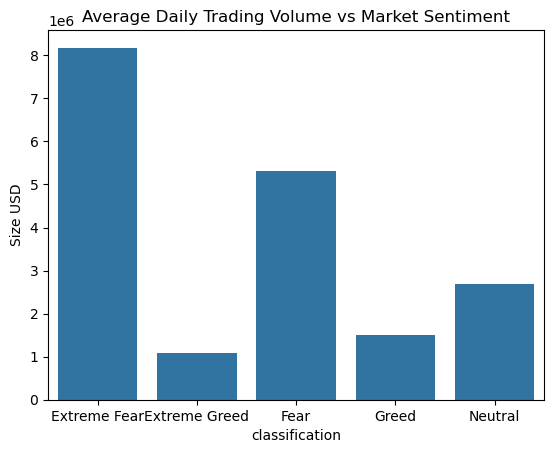

In [23]:
# Average daily volume by sentiment
volume_trend = merged_df.groupby('classification')['Size USD'].mean().reset_index()
print(volume_trend)

# Plot
sns.barplot(x='classification', y='Size USD', data=volume_trend)
plt.title("Average Daily Trading Volume vs Market Sentiment")
plt.savefig('outputs/avg_volume_vs_sentiment.png')
plt.show()

                 Closed PnL  Size USD  Execution Price  Start Position  \
Closed PnL         1.000000  0.325759        -0.024298        0.072768   
Size USD           0.325759  1.000000         0.206365       -0.148356   
Execution Price   -0.024298  0.206365         1.000000       -0.076041   
Start Position     0.072768 -0.148356        -0.076041        1.000000   
Fee                0.294822  0.978430         0.208337       -0.160055   
Size Tokens       -0.050904  0.223940        -0.037220       -0.131481   

                      Fee  Size Tokens  
Closed PnL       0.294822    -0.050904  
Size USD         0.978430     0.223940  
Execution Price  0.208337    -0.037220  
Start Position  -0.160055    -0.131481  
Fee              1.000000     0.219074  
Size Tokens      0.219074     1.000000  


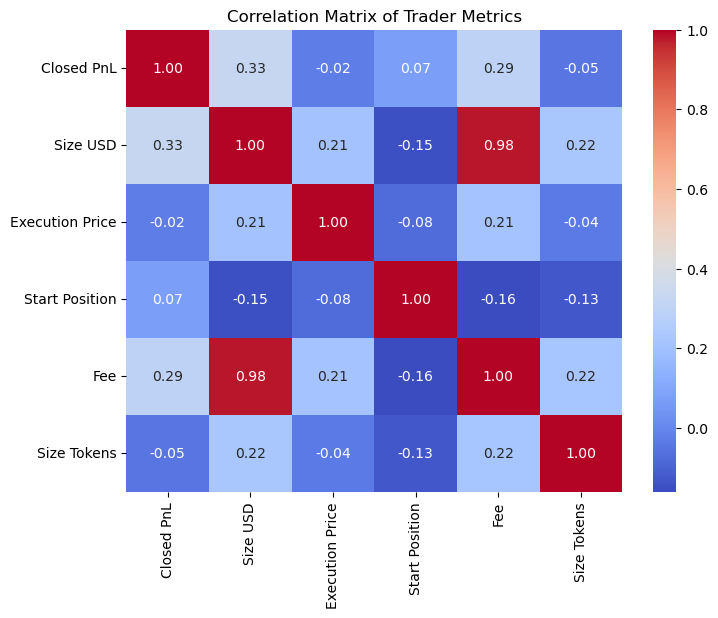

In [24]:
# Select numeric columns for correlation
numeric_cols = ['Closed PnL', 'Size USD', 'Execution Price', 'Start Position', 'Fee', 'Size Tokens']

# Calculate correlation matrix
corr = merged_df[numeric_cols].corr()
print(corr)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Trader Metrics")
plt.savefig('outputs/correlation_matrix.png')
plt.show()

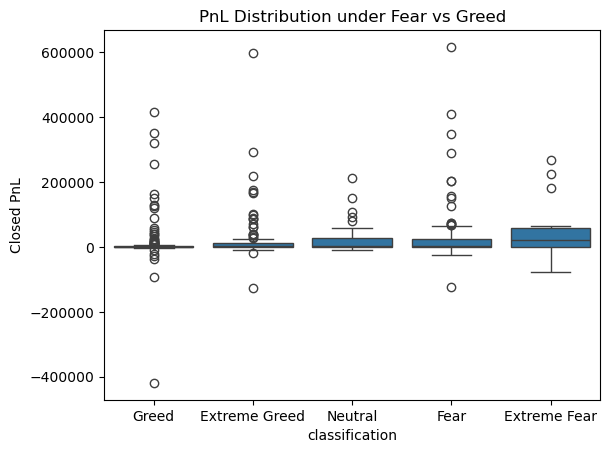

In [25]:
# Boxplot to see distribution
sns.boxplot(x='classification', y='Closed PnL', data=merged_df)
plt.title("PnL Distribution under Fear vs Greed")
plt.savefig('outputs/pnl_distribution.png')
plt.show()

In [26]:
# -----------------------------
# Advanced Insights Generator
# -----------------------------

import pandas as pd

# 1️ Overall PnL trends by sentiment
pnl_summary = merged_df.groupby('classification')['Closed PnL'].agg(['mean', 'median', 'sum'])
print("1️ Profit/Loss Summary by Sentiment:\n", pnl_summary, "\n")

# 2️ Average trading volume by sentiment
volume_summary = merged_df.groupby('classification')['Size USD'].agg(['mean', 'median', 'sum'])
print("2️ Trading Volume Summary by Sentiment:\n", volume_summary, "\n")

# 3️ Average leverage by sentiment (if available)
if 'Leverage' in merged_df.columns:
    leverage_summary = merged_df.groupby('classification')['Leverage'].agg(['mean', 'median'])
    print("3️ Leverage Summary by Sentiment:\n", leverage_summary, "\n")

# 4️ Most common trade side by sentiment
side_summary = merged_df.groupby('classification')['Side'].agg(lambda x: x.value_counts().idxmax())
print("4️ Dominant Trade Side by Sentiment:\n", side_summary, "\n")

# 5️ Correlation insights
numeric_cols = ['Closed PnL', 'Size USD', 'Execution Price', 'Start Position', 'Fee', 'Size Tokens']
corr = merged_df[numeric_cols].corr()
print("5️ Correlation Matrix:\n", corr, "\n")

# 6️ Simple textual insights
insights = []

# PnL Insight
fear_pnl = pnl_summary.loc['Fear', 'mean'] if 'Fear' in pnl_summary.index else None
greed_pnl = pnl_summary.loc['Greed', 'mean'] if 'Greed' in pnl_summary.index else None
if fear_pnl is not None and greed_pnl is not None:
    if greed_pnl > fear_pnl:
        insights.append(f"Traders are generally more profitable on Greed days (avg PnL: {greed_pnl:.2f}) than Fear days (avg PnL: {fear_pnl:.2f}).")
    else:
        insights.append(f"Traders are generally more profitable on Fear days (avg PnL: {fear_pnl:.2f}) than Greed days (avg PnL: {greed_pnl:.2f}).")

# Volume Insight
fear_vol = volume_summary.loc['Fear', 'mean'] if 'Fear' in volume_summary.index else None
greed_vol = volume_summary.loc['Greed', 'mean'] if 'Greed' in volume_summary.index else None
if fear_vol and greed_vol:
    if fear_vol > greed_vol:
        insights.append(f"Trading volume tends to be higher during Fear periods (avg volume: {fear_vol:.2f}) compared to Greed periods (avg volume: {greed_vol:.2f}).")
    else:
        insights.append(f"Trading volume tends to be higher during Greed periods (avg volume: {greed_vol:.2f}) compared to Fear periods (avg volume: {fear_vol:.2f}).")

# Leverage Insight
if 'Leverage' in merged_df.columns:
    fear_lev = leverage_summary.loc['Fear', 'mean']
    greed_lev = leverage_summary.loc['Greed', 'mean']
    insights.append(f"Average leverage is higher on Greed days ({greed_lev:.2f}) than Fear days ({fear_lev:.2f}), indicating higher risk-taking during Greed.")

# Side Insight
dominant_fear_side = side_summary.get('Fear', None)
dominant_greed_side = side_summary.get('Greed', None)
if dominant_fear_side and dominant_greed_side:
    insights.append(f"Most traders tend to '{dominant_fear_side}' on Fear days and '{dominant_greed_side}' on Greed days.")

# Print all textual insights
print("6️ Key Advanced Insights:")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

1️ Profit/Loss Summary by Sentiment:
                         mean        median           sum
classification                                          
Extreme Fear    52793.589178  22561.739636  7.391102e+05
Extreme Greed   23817.292199   3127.536297  2.715171e+06
Fear            36891.818040   1412.314654  3.357155e+06
Greed           11140.566181    678.475928  2.150129e+06
Neutral         19297.323516   1818.573295  1.292921e+06 

2️ Trading Volume Summary by Sentiment:
                         mean       median           sum
classification                                         
Extreme Fear    8.177447e+06  6908174.765  1.144843e+08
Extreme Greed   1.091800e+06   488383.250  1.244652e+08
Fear            5.311261e+06   488904.190  4.833248e+08
Greed           1.495246e+06   207990.800  2.885825e+08
Neutral         2.690180e+06   403002.800  1.802421e+08 

4️ Dominant Trade Side by Sentiment:
 classification
Extreme Fear      BUY
Extreme Greed    SELL
Fear              BUY
Greed  